# Customer Churn Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

#### Data Preparation based on EDA

In [2]:
def datapreparation(filepath):
    
    df = pd.read_csv(filepath)
    df.drop(["customerID"], inplace = True, axis = 1)
    
    df.TotalCharges = df.TotalCharges.replace(" ",np.nan)
    df.TotalCharges.fillna(0, inplace = True)
    df.TotalCharges = df.TotalCharges.astype(float)
    
    cols1 = ['Partner', 'Dependents', 'PaperlessBilling', 'Churn', 'PhoneService']
    for col in cols1:
        df[col] = df[col].apply(lambda x: 0 if x == "No" else 1)
   
    df.gender = df.gender.apply(lambda x: 0 if x == "Male" else 1)
    df.MultipleLines = df.MultipleLines.map({'No phone service': 0, 'No': 0, 'Yes': 1})
    
    cols2 = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
    for col in cols2:
        df[col] = df[col].map({'No internet service': 0, 'No': 0, 'Yes': 1})
    
    df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True)
    
    return df

In [3]:
df = datapreparation(filepath = "/Users/sakshisingh/Sakshi/Projects/Customer-Survival-Analysis-and-Churn-Prediction/Data/Telco_Cusomer_Churn.csv")
df.head()

/var/folders/41/f97k2tlx2xnftr7h0sg_bp4r0000gn/T/ipykernel_62456/562632756.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.TotalCharges.fillna(0, inplace = True)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,29.85,29.85,0,False,False,False,False,False,True,False
1,0,0,0,0,34,1,0,1,0,1,...,56.95,1889.50,0,False,False,True,False,False,False,True
2,0,0,0,0,2,1,0,1,1,0,...,53.85,108.15,1,False,False,False,False,False,False,True
3,0,0,0,0,45,0,0,1,0,1,...,42.30,1840.75,0,False,False,True,False,False,False,False
4,1,0,0,0,2,1,0,0,0,0,...,70.70,151.65,1,True,False,False,False,False,True,False


In [4]:
df.isnull().any().any()

np.False_

## Model Building

I am going to build and tune random forest model because in this case tree based method would perform better. I am also interested in individual customer's churning probability and in understanding how the model calculates it using Shap values.

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [8]:
train, test = train_test_split(df, test_size=0.2, random_state=111, stratify = df.Churn)

In [9]:
x = df.columns[df.columns!="Churn"]
y = "Churn"
train_x = train[x]
train_y = train[y]
test_x = test[x]
test_y = test[y]

In [10]:
#function for model fitting
def churn_prediction(algo, training_x, training_y, testing_x, testing_y, cols, cf = 'coefficients'):
    algo.fit(training_x,training_y)
    predictions = algo.predict(testing_x)
    probabilities = algo.predict_proba(testing_x)[:,1]
    
    #coeffs
    if cf == "coefficients":
        coefficients = pd.DataFrame(algo.coef_.ravel())
    elif cf == "features":
        coefficients = pd.DataFrame(algo.feature_importances_)
        
    column_df = pd.DataFrame(cols)
    coef_sumry = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algo)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,probabilities) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities)
    
    plt.subplot(222)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    
    plt.subplot(212)
    sns.barplot(x = coef_sumry["features"] ,y = coef_sumry["coefficients"])
    plt.title('Feature Importances')
    plt.xticks(rotation="vertical")
    
    plt.show()

### Hyperparameters Tuning

#### Grid 1: Selecting class weight and estimators

In [11]:
param_grid1 = {'max_features':['auto', 'sqrt', 'log2', None],
          'n_estimators':[300, 500, 700, 900, 1100, 1300]
         }

rf_model = RandomForestClassifier()
grid1 = GridSearchCV(estimator=rf_model, param_grid=param_grid1, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid1.fit(train_x, train_y)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
18 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py", line 1358, in wrapper
    estimator._validate_params()
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py", line 471, in _validate_params
    validate_parameter_constraints(
  File "/opt/homebrew/lib/python3.10/site-packages/

,estimator,RandomForestClassifier()
,param_grid,"{'max_features': ['auto', 'sqrt', ...], 'n_estimators': [300, 500, ...]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,1100


In [12]:
grid1.best_estimator_

,n_estimators,1100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


<Axes: xlabel='param_max_features', ylabel='param_n_estimators'>

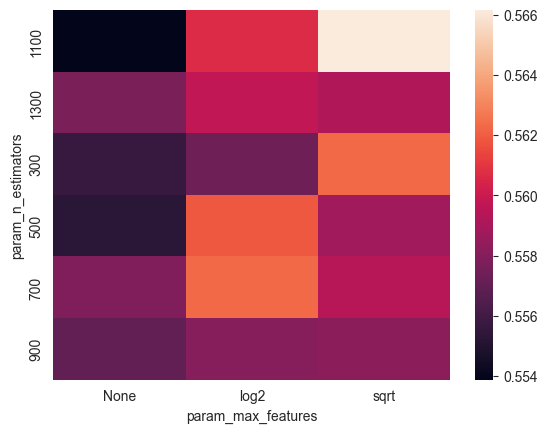

In [13]:
dt = pd.DataFrame(grid1.cv_results_)
dt.param_max_features = dt.param_max_features.astype(str)
dt.param_n_estimators = dt.param_n_estimators.astype(str)

table = pd.pivot_table(dt, values='mean_test_score', index='param_n_estimators', 
                       columns='param_max_features')
     
sns.heatmap(table)

In [14]:
grid1.best_score_

np.float64(0.5661573128131221)

#### Grid 2: Selecting max depth and split criterion

In [16]:
param_grid2 = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],  
    "bootstrap": [True, False]
}


rf_model = RandomForestClassifier(random_state=42)
grid2 = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid2,
    n_jobs=-1,
    cv=3,
    verbose=1,
    scoring="f1"
)
grid2.fit(train_x, train_y)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'bootstrap': [True, False], 'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [1, 2, ...], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [17]:
grid2.best_estimator_

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,10
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [19]:
dt = pd.DataFrame(grid2.cv_results_)
[c for c in dt.columns if c.startswith("param_")]

['param_bootstrap',
 'param_max_depth',
 'param_max_features',
 'param_min_samples_leaf',
 'param_min_samples_split',
 'param_n_estimators']

<Axes: xlabel='param_max_features', ylabel='param_max_depth'>

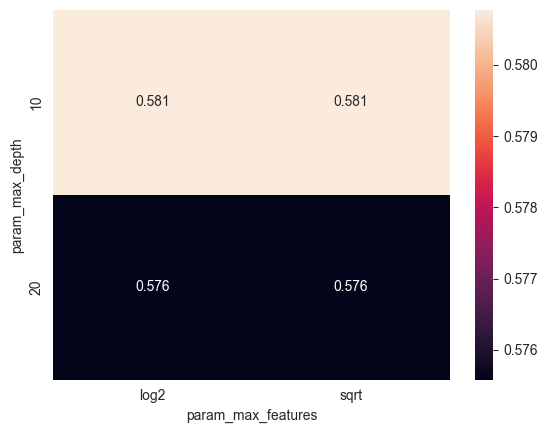

In [20]:
table = pd.pivot_table(
    dt,
    values="mean_test_score",
    index="param_max_depth",
    columns="param_max_features",
    aggfunc="max"
)

sns.heatmap(table, annot=True, fmt=".3f")


<Axes: xlabel='param_n_estimators', ylabel='param_max_depth'>

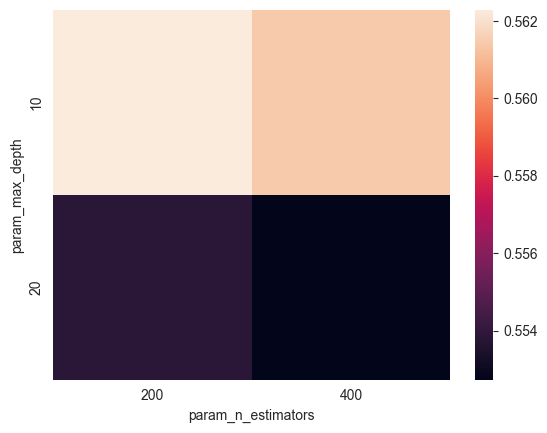

In [21]:
table = pd.pivot_table(dt, values='mean_test_score', index='param_max_depth', 
                       columns='param_n_estimators')
     
sns.heatmap(table)

In [22]:
grid2.best_score_

np.float64(0.5807713725892039)

Checking if other depth and estimator value results better

In [24]:
param_grid2_2["max_features"]
param_grid2_2 = {
    "n_estimators": [200, 400, 600],
    "max_depth": [None, 10, 20],
    "max_features": ["sqrt", "log2", None],   # ✅ NOT "auto"
}
rf_model = RandomForestClassifier(random_state=42)
grid2_2 = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid2_2,
    n_jobs=-1,
    cv=3,
    verbose=1,
    scoring="f1"
)
grid2_2.fit(train_x, train_y)


Fitting 3 folds for each of 27 candidates, totalling 81 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2', ...], 'n_estimators': [200, 400, ...]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [25]:
grid2_2.best_estimator_

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [26]:
grid2_2.best_score_

np.float64(0.579417216079068)

#### Grid 3: Selecting minimum samples leaf and split

In [28]:
param_grid3["max_features"]
param_grid3["max_features"] = ["sqrt", "log2", None]
rf_model = RandomForestClassifier(random_state=42)

grid3 = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid3,
    n_jobs=-1,
    cv=3,
    verbose=1,
    scoring="f1"
)

grid3.fit(train_x, train_y)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'criterion': ['entropy'], 'max_depth': [10], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [1, 3, ...], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,1000


In [29]:
grid3.best_estimator_

,n_estimators,1000
,criterion,'entropy'
,max_depth,10
,min_samples_split,6
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


<Axes: xlabel='param_min_samples_split', ylabel='param_min_samples_leaf'>

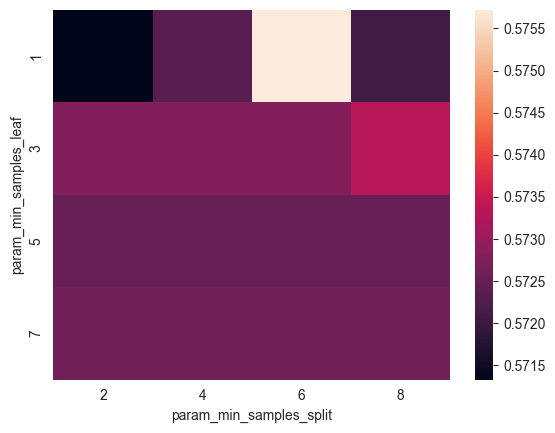

In [30]:
dt = pd.DataFrame(grid3.cv_results_)

table = pd.pivot_table(dt, values='mean_test_score', index='param_min_samples_leaf', 
                       columns='param_min_samples_split')
     
sns.heatmap(table)

In [31]:
grid3.best_score_

np.float64(0.5802564364816168)

#### Grid 4: Selecting class weight

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# --- FIX param_grid4 (remove invalid "auto" for new sklearn) ---
if "max_features" in param_grid4:
    # remove "auto" if present
    param_grid4["max_features"] = [
        v for v in param_grid4["max_features"]
        if v != "auto"
    ]
    # if you removed everything (or grid was bad), set valid defaults
    if len(param_grid4["max_features"]) == 0:
        param_grid4["max_features"] = ["sqrt", "log2", None]
else:
    # if you forgot to include max_features at all, add it
    param_grid4["max_features"] = ["sqrt", "log2", None]

# --- GridSearch ---
rf_model = RandomForestClassifier(random_state=42)

grid4 = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid4,
    n_jobs=-1,
    cv=3,
    verbose=1,
    scoring="f1"
)

print("Final param_grid being used:\n", grid4.param_grid)  # sanity check
grid4.fit(train_x, train_y)

print("Best params:", grid4.best_params_)
print("Best CV F1:", grid4.best_score_)


Final param_grid being used:
 {'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}], 'max_features': ['sqrt', 'log2', None], 'n_estimators': [1000], 'criterion': ['entropy'], 'max_depth': [10], 'min_samples_leaf': [1], 'min_samples_split': [8]}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best params: {'class_weight': {0: 1, 1: 3}, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 1000}
Best CV F1: 0.6330360513411737


In [34]:
grid4.best_estimator_

,n_estimators,1000
,criterion,'entropy'
,max_depth,10
,min_samples_split,8
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


<Axes: ylabel='param_class_weight'>

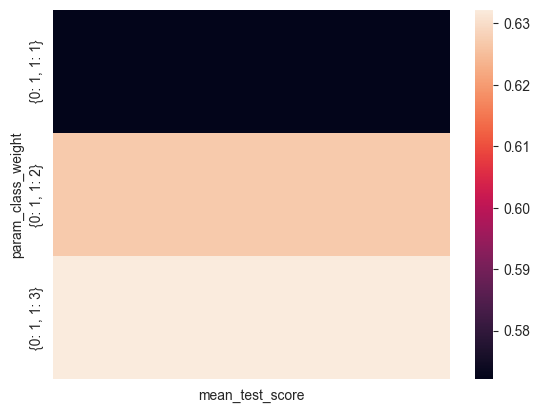

In [35]:
dt = pd.DataFrame(grid4.cv_results_)
dt.param_class_weight = dt.param_class_weight.astype(str)
table = pd.pivot_table(dt, values='mean_test_score', index='param_class_weight')
     
sns.heatmap(table)

In [36]:
grid4.best_score_

np.float64(0.6330360513411737)

### Final Model

In [46]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    bootstrap=True,
    ccp_alpha=0.0,
    class_weight={0: 1, 1: 2},
    criterion="entropy",
    max_depth=10,
    max_features="sqrt",   
    min_samples_leaf=1,
    min_samples_split=8,
    n_estimators=1000,
    random_state=42
)


RandomForestClassifier(class_weight={0: 1, 1: 2}, criterion='entropy',
                       max_depth=10, min_samples_split=8, n_estimators=1000,
                       random_state=42)

 Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.84      0.85      1035
           1       0.59      0.66      0.62       374

    accuracy                           0.79      1409
   macro avg       0.73      0.75      0.74      1409
weighted avg       0.80      0.79      0.79      1409

Accuracy   Score :  0.7877927608232789
Area under curve :  0.8482936784727066 



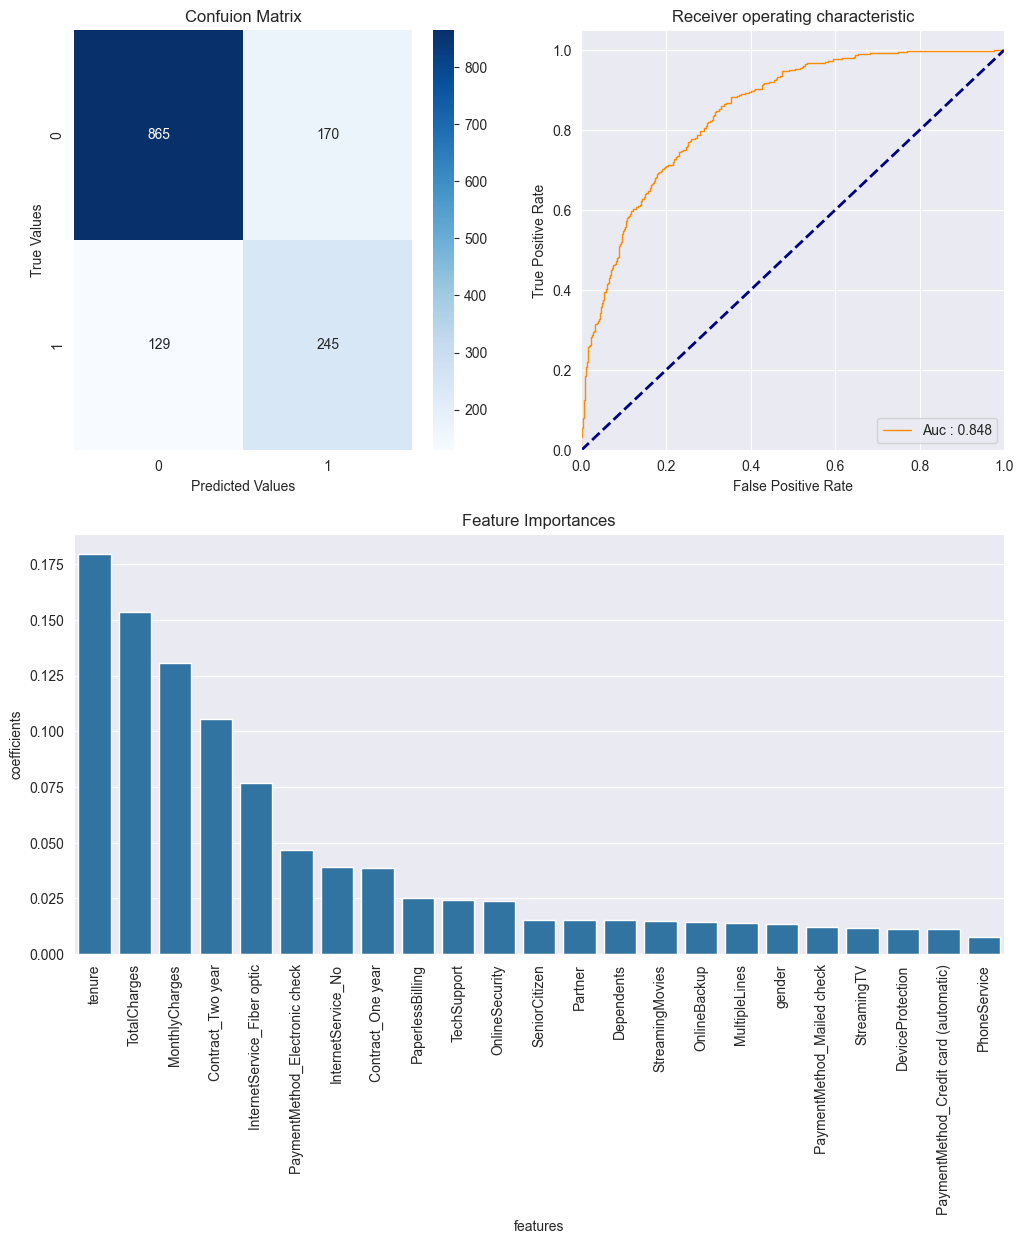

In [39]:
churn_prediction(model, train_x, train_y, test_x, test_y, x,"features")

Checking the model's performance on train data itself

In [40]:
train_scores = cross_val_score(model, train_x, train_y, cv = 5, scoring='f1')
train_scores

array([0.59815951, 0.66666667, 0.62559242, 0.58096828, 0.63622047])

In [41]:
np.mean(train_scores)

np.float64(0.6215214691678245)

In [43]:
from sklearn.metrics import precision_recall_curve

y_prob = model.predict_proba(test_x)[:, 1]
prec, rec, thr = precision_recall_curve(test_y, y_prob)

# Example: pick threshold for recall >= 0.75
target_recall = 0.75
idx = next(i for i, r in enumerate(rec) if r >= target_recall)
best_threshold = thr[idx]

best_threshold

np.float64(0.0007886126679477855)

In [44]:
y_pred_new = (y_prob >= best_threshold).astype(int)


As we can see that the performance of the model on test data is same as training data. So, we can conclude that there is no overfitting and underfitting.

#### XGBoost Model & LightGBM Model

In [71]:
!pip3 install xgboost lightgbm


In [72]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV

def find_best_threshold(y_true, y_prob, metric="f1"):
    thresholds = np.linspace(0.05, 0.95, 91)
    rows = []

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        rows.append({
            "threshold": t,
            "auc": roc_auc_score(y_true, y_prob),
            "precision_1": precision_score(y_true, y_pred, zero_division=0),
            "recall_1": recall_score(y_true, y_pred, zero_division=0),
            "f1_1": f1_score(y_true, y_pred, zero_division=0),
        })

    df = pd.DataFrame(rows)

    if metric == "f1":
        best = df.loc[df["f1_1"].idxmax()]
    elif metric == "recall":
        best = df.loc[df["recall_1"].idxmax()]
    elif metric == "precision":
        best = df.loc[df["precision_1"].idxmax()]
    else:
        raise ValueError("metric must be one of: f1, recall, precision")

    return best, df

def evaluate_model(name, model, test_x, test_y, metric_for_threshold="f1"):
    prob = model.predict_proba(test_x)[:, 1]
    best_thr, _ = find_best_threshold(test_y, prob, metric=metric_for_threshold)

    return {
        "model": name,
        "auc": float(best_thr["auc"]),
        "best_threshold": float(best_thr["threshold"]),
        "precision_1": float(best_thr["precision_1"]),
        "recall_1": float(best_thr["recall_1"]),
        "f1_1": float(best_thr["f1_1"]),
    }


In [76]:
rf_model = model
rf_model.fit(train_x, train_y)


,n_estimators,1000
,criterion,'entropy'
,max_depth,10
,min_samples_split,8
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [78]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

pos_weight = (train_y == 0).sum() / (train_y == 1).sum()

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=pos_weight
)

xgb_param = {
    "n_estimators": [300, 600, 900, 1200],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [2, 3, 4, 5],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0, 0.1, 0.3],
    "reg_lambda": [1, 3, 5, 10],
}

xgb_search = RandomizedSearchCV(
    xgb,
    param_distributions=xgb_param,
    n_iter=25,
    scoring="f1",
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

xgb_search.fit(train_x, train_y)
xgb_model = xgb_search.best_estimator_

print("Best XGB params:", xgb_search.best_params_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best XGB params: {'subsample': 0.9, 'reg_lambda': 5, 'n_estimators': 600, 'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1.0}


In [79]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

def best_threshold_metrics(y_true, y_prob, metric="f1"):
    thresholds = np.linspace(0.05, 0.95, 91)
    best_row = None
    best_val = -1

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        p = precision_score(y_true, y_pred, zero_division=0)
        r = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        val = {"precision": p, "recall": r, "f1": f1}[metric]
        if val > best_val:
            best_val = val
            best_row = (t, p, r, f1)

    return best_row  # threshold, precision, recall, f1

def evaluate(name, mdl, metric_for_threshold="f1"):
    prob = mdl.predict_proba(test_x)[:, 1]
    auc = roc_auc_score(test_y, prob)
    t, p, r, f1 = best_threshold_metrics(test_y, prob, metric=metric_for_threshold)
    return {
        "Model": name,
        "AUC": round(auc, 4),
        "Best_Threshold": round(t, 3),
        "Precision(Churn=1)": round(p, 4),
        "Recall(Churn=1)": round(r, 4),
        "F1(Churn=1)": round(f1, 4),
    }

comparison = pd.DataFrame([
    evaluate("RandomForest", rf_model, metric_for_threshold="f1"),
    evaluate("XGBoost (tuned)", xgb_model, metric_for_threshold="f1"),
]).sort_values(by=["F1(Churn=1)", "AUC"], ascending=False)

comparison


,Model,AUC,Best_Threshold,Precision(Churn=1),Recall(Churn=1),F1(Churn=1)
1,XGBoost (tuned),0.8525,0.60,0.5867,0.7059,0.6408
0,RandomForest,0.8483,0.47,0.5814,0.6872,0.6299


In [80]:
from sklearn.metrics import average_precision_score, roc_auc_score

# RandomForest PR-AUC
rf_prob = rf_model.predict_proba(test_x)[:, 1]
rf_pr_auc = average_precision_score(test_y, rf_prob)
rf_roc_auc = roc_auc_score(test_y, rf_prob)

# XGBoost PR-AUC
xgb_prob = xgb_model.predict_proba(test_x)[:, 1]
xgb_pr_auc = average_precision_score(test_y, xgb_prob)
xgb_roc_auc = roc_auc_score(test_y, xgb_prob)

print("RandomForest  ROC-AUC:", rf_roc_auc)
print("RandomForest  PR-AUC :", rf_pr_auc)

print("XGBoost       ROC-AUC:", xgb_roc_auc)
print("XGBoost       PR-AUC :", xgb_pr_auc)


RandomForest  ROC-AUC: 0.8482936784727066
RandomForest  PR-AUC : 0.6728896870497811
XGBoost       ROC-AUC: 0.8524684181973184
XGBoost       PR-AUC : 0.6754047172843847


#### Saving model

In [42]:
import pickle
pickle.dump(model, open('model.pkl','wb'))

## Explaining the model

In [51]:
import eli5
from eli5.sklearn import PermutationImportance

from pdpbox import pdp, info_plots

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [53]:
best_model = grid4.best_estimator_   # this is already fitted after grid4.fit(...)
perm = PermutationImportance(best_model, random_state=1).fit(test_x, test_y)
eli5.show_weights(perm, feature_names=test_x.columns.tolist())

Weight,Feature
0.0202 ± 0.0106,InternetService_Fiber optic
0.0068 ± 0.0089,Contract_One year
0.0053 ± 0.0060,PaymentMethod_Electronic check
0.0040 ± 0.0038,InternetService_No
0.0035 ± 0.0031,OnlineSecurity
0.0028 ± 0.0030,gender
0.0026 ± 0.0029,DeviceProtection
0.0020 ± 0.0023,SeniorCitizen
0.0018 ± 0.0146,Contract_Two year
0.0014 ± 0.0020,MultipleLines


Visualizing how the partial dependance plots look for top features

### Shap Values

In [63]:
import shap 
shap.initjs()

import joblib

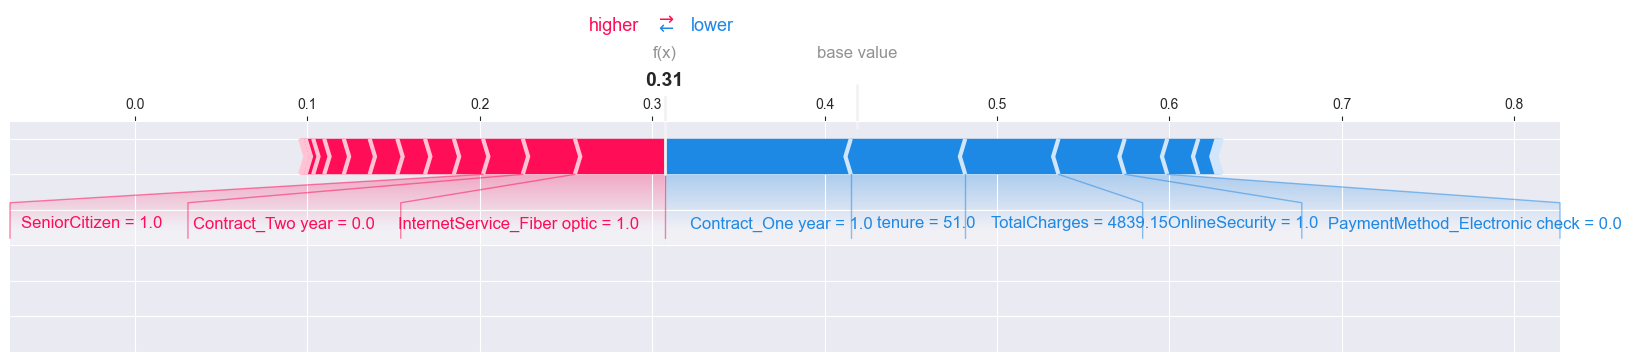

In [65]:
import shap

explainer = shap.TreeExplainer(model)

x1 = test_x.iloc[[0]]           # ✅ keeps it 2D (1, n_features)

shap_values = explainer.shap_values(x1)

# case 1: list output (most common for older SHAP)
if isinstance(shap_values, list):
    shap.force_plot(
        explainer.expected_value[1],
        shap_values[1][0],       # ✅ row 0, class 1
        x1.iloc[0],
        matplotlib=True
    )

# case 2: ndarray output (newer SHAP sometimes gives 3D)
else:
    # shap_values shape could be (1, n_features, 2)
    shap.force_plot(
        explainer.expected_value[1],
        shap_values[0, :, 1],     # ✅ row 0, class 1
        x1.iloc[0],
        matplotlib=True
    )


In [66]:
# Saving Explainer
ex_filename = 'explainer.bz2'
joblib.dump(explainer, filename=ex_filename, compress=('bz2', 9))

['explainer.bz2']

### Gauge Chart 

In [68]:
from matplotlib.patches import Circle, Wedge, Rectangle

def degree_range(n): 
    start = np.linspace(0,180,n+1, endpoint=True)[0:-1]
    end = np.linspace(0,180,n+1, endpoint=True)[1::]
    mid_points = start + ((end-start)/2.)
    return np.c_[start, end], mid_points

def rot_text(ang): 
    rotation = np.degrees(np.radians(ang) * np.pi / np.pi - np.radians(90))
    return rotation

def gauge(labels=['LOW','MEDIUM','HIGH','EXTREME'], \
          colors=['#007A00','#0063BF','#FFCC00','#ED1C24'], Probability=1, fname=False): 
    
    N = len(labels)
    colors = colors[::-1]

    """
    begins the plotting
    """
    
    fig, ax = plt.subplots()

    ang_range, mid_points = degree_range(4)

    labels = labels[::-1]
    
    """
    plots the sectors and the arcs
    """
    patches = []
    for ang, c in zip(ang_range, colors): 
        # sectors
        patches.append(Wedge((0.,0.), .4, *ang, facecolor='w', lw=2))
        # arcs
        patches.append(Wedge((0.,0.), .4, *ang, width=0.10, facecolor=c, lw=2, alpha=0.5))
    
    [ax.add_patch(p) for p in patches]

    
    """
    set the labels (e.g. 'LOW','MEDIUM',...)
    """

    for mid, lab in zip(mid_points, labels): 

        ax.text(0.35 * np.cos(np.radians(mid)), 0.35 * np.sin(np.radians(mid)), lab, \
            horizontalalignment='center', verticalalignment='center', fontsize=14, \
            fontweight='bold', rotation = rot_text(mid))

    """
    set the bottom banner and the title
    """
    r = Rectangle((-0.4,-0.1),0.8,0.1, facecolor='w', lw=2)
    ax.add_patch(r)
    
    ax.text(0, -0.05, 'Churn Probability ' + np.round(Probability,2).astype(str), horizontalalignment='center', \
         verticalalignment='center', fontsize=22, fontweight='bold')

    """
    plots the arrow now
    """
    
    pos = (1-Probability)*180
    ax.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)), \
                 width=0.04, head_width=0.09, head_length=0.1, fc='k', ec='k')
    
    ax.add_patch(Circle((0, 0), radius=0.02, facecolor='k'))
    ax.add_patch(Circle((0, 0), radius=0.01, facecolor='w', zorder=11))

    """
    removes frame and ticks, and makes axis equal and tight
    """
    
    ax.set_frame_on(False)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    ax.axis('equal')
    plt.tight_layout()
    if fname:
        fig.savefig(fname, dpi=200)

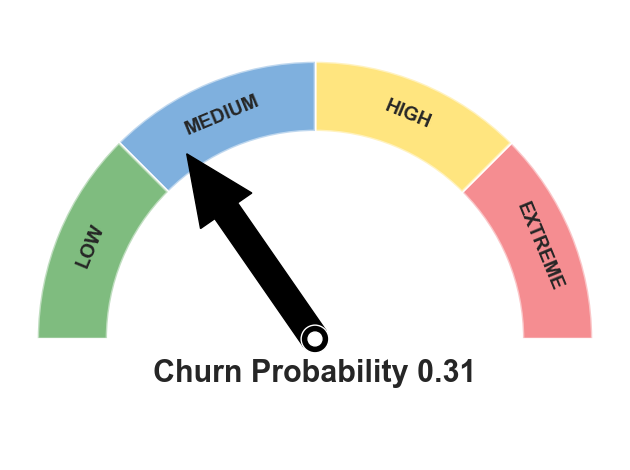

In [69]:
gauge(Probability=model.predict_proba(test_x.iloc[0:1])[0,1])

Final Features

In [70]:
test_x.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'InternetService_Fiber optic', 'InternetService_No',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')